In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

In [2]:
import sys
sys.path.insert(1, '/home/gusinskaia/scintools/scintools')
import ththmod as THTH

In [7]:
import baseband
from baseband import guppi
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pulsarbat as pb
from glob import glob
import os, sys, math, time

from astropy.time import Time
from astropy import units as u
from astropy.visualization import quantity_support

from astropy import constants as const

import numpy as np
import astropy
from matplotlib.colors import LogNorm

import matplotlib as mpl
from scipy.sparse.linalg import eigsh
from scipy.optimize import curve_fit
import scipy.linalg

import load_data as ld
import ds_psr as dsa



plt.rcParams['figure.dpi'] = 50
print (baseband.__version__)
print (pb.__version__)
print (astropy.__version__)


import concurrent.futures
import datetime


4.0.1
0.0.3
3.0


In [8]:
trdir='/mnt/scratch-lustre/gusinskaia/triple_system/'
odir=trdir+'dss_mean/'
fitdir=trdir+'for_fit/'
npydir=trdir+'npys_vels/'
imdir=trdir+'fitted_figures/'
vlbidir=trdir+'dss_realvlba/'
longdir=trdir+'dss_long/'
onetotwo_dir=trdir+'dss_1to2/'
twotofour_dir=trdir+'dss_2to4/'
armdir=trdir+'one_armed_arc/'
nsdir=trdir+'dss_wsrt_wnoise/'

spec_pieces=np.array([[1301,1317],[1321,1337],[1341,1357],[1361,1377],[1381,1397],
                      [1401,1417],[1421,1437],[1441,1457]])

In [9]:
list_2to4=sorted(glob(nsdir+'*.npz'))
len(list_2to4)

12

In [10]:
sp=ld.load_triple(list_2to4[0])

(1439, 512)
1439
512
[1439  512]
(1439, 512)
1439
512
[1439  512]
(1439, 512)


In [15]:
sp=dsa.load_triple_spectrum(list_2to4[1], factor=[8,1])

(1079, 512)
[ 2.  2.  2.  2.]
512
[1070  512]
(133, 512)
[ 2.  2.  2.  2.]
512
[1070  512]
(133, 512)


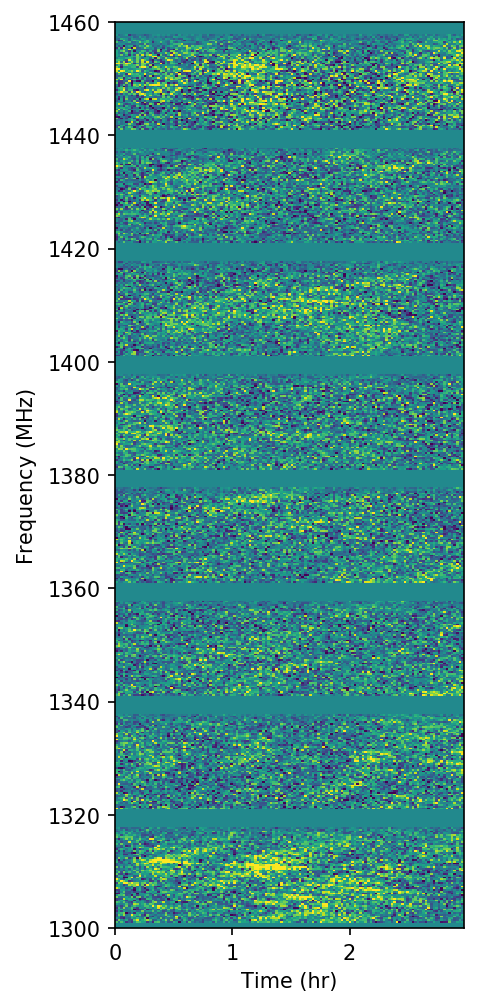

In [16]:
sp.plot_ds()